<a href="https://colab.research.google.com/github/AleardoKandiah/Semantic-Segmentation-of-retinal-disease-images/blob/main/segmentationnote.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OCT Segmentation
This is a small segmentation tutorial on OCT images.

The U-net model implementation comes from this kernel : https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277

In [ ]:
# Dataset 
from google.colab import drive
drive.mount('/content/drive/')
!ls "/content/drive/"

import os
import numpy as np
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt

# keras
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import backend as K

import tensorflow as tf

x = tf.constant([1.8, 2.2], dtype=tf.float32)
tf.cast(x, tf.int32)

Mounted at /content/drive/
MyDrive


<tf.Tensor: shape=(2,), dtype=int32, numpy=array([1, 2], dtype=int32)>

In [ ]:
# Settings
input_path = os.path.join('drive', 'MyDrive', 'Data', '2015_BOE_Chiu', '2015_BOE_Chiu')
subject_path = [os.path.join(input_path, 'Subject_0{}.mat'.format(i)) for i in range(1, 10)] + [os.path.join(input_path, 'Subject_10.mat')]

data_indexes = [10, 15, 20, 25, 28, 30, 32, 35, 40, 45, 50]

width = 768
height = 496

## Data visualization

In [ ]:
mat = scipy.io.loadmat(subject_path[0])
img_tensor = mat['images']
manual_fluid_tensor_1 = mat['manualFluid1']

img_array = np.transpose(img_tensor, (2, 0, 1))
manual_fluid_array = np.transpose(manual_fluid_tensor_1, (2, 0, 1))

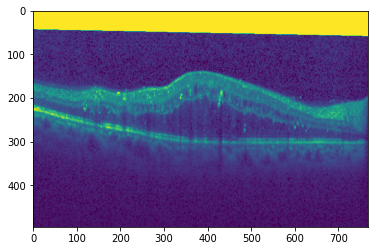

In [ ]:
plt.imshow(img_array[25])

In [ ]:
print(img_array[25])

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [  0   0  14 ...   6   0   0]
 [ 15  15  16 ...  10   0   0]
 [ 15  17  16 ...  13   0   0]]


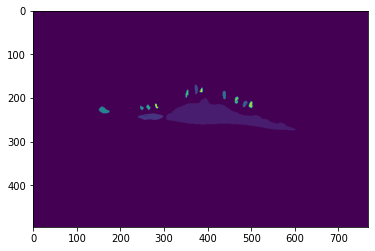

In [ ]:
plt.imshow(manual_fluid_array[25])

## Segmentation net training

In [ ]:
def thresh(x):
    if x == 0:
        return 0
    else:
        return 1

thresh = np.vectorize(thresh, otypes=[np.float])

def create_dataset(paths):
    x = []
    y = []
    
    for path in paths:
        mat = scipy.io.loadmat(path)
        img_tensor = mat['images']
        fluid_tensor = mat['manualFluid1']
        
        img_array = np.transpose(img_tensor, (2, 0 ,1)) / 255
        fluid_array = np.transpose(fluid_tensor, (2, 0 ,1))
        fluid_array = thresh(fluid_array)
        
        for idx in data_indexes:
            x += [np.expand_dims(img_array[idx], 2)]
            y += [np.expand_dims(fluid_array[idx], 2)]
        
    return np.array(x), np.array(y)

x_train, y_train = create_dataset(subject_path[:9])
x_val, y_val = create_dataset(subject_path[9:])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


In [ ]:
# CNN model
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        # y_pred_ = tf.to_int32(y_pred > t)
        y_pred_ = y_pred > t
        score, up_opt = tf.compat.v1.metrics.mean_iou(y_true, y_pred_, num_classes=2)
        # K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)


# tf.compat.v1.metrics.mean_iou(
#     labels,
#     predictions,
#     num_classes,
#     weights=None,
#     metrics_collections=None,
#     updates_collections=None,
#     name=None
# )



inputs = Input((height, width, 1))

c1_1 = Conv2D(8, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(inputs)
c1_2 = Conv2D(8, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c1_1)
p1 = MaxPooling2D((2, 2))(c1_2)

c2_1 = Conv2D(12, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p1)
c2_2 = Conv2D(12, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c2_1)
p2 = MaxPooling2D((2, 2))(c2_2)

c3_1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p2)
c3_2 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c3_1)
p3 = MaxPooling2D((2, 2))(c3_2)

c4_1 = Conv2D(24, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p3)
c4_2 = Conv2D(24, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c4_1)
p4 = MaxPooling2D((2, 2))(c4_2)

c5_1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p4)
c5_2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c5_1)

c6_t = Conv2DTranspose(24, (2, 2), strides=(2, 2), padding='same') (c5_2)
c6_c = concatenate([c6_t, c4_2])
c6_1 = Conv2D(24, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c6_c)
c6_2 = Conv2D(24, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c6_1)

c7_t = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c6_2)
c7_c = concatenate([c7_t, c3_2])
c7_1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c7_c)
c7_2 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c7_1)

c8_t = Conv2DTranspose(12, (2, 2), strides=(2, 2), padding='same') (c7_2)
c8_c = concatenate([c8_t, c2_2])
c8_1 = Conv2D(12, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c8_c)
c8_2 = Conv2D(12, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c8_1)

c9_t = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8_2)
c9_c = concatenate([c9_t, c1_2])
c9_1 = Conv2D(8, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c9_c)
c9_2 = Conv2D(8, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c9_1)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9_2)

model = Model(inputs=[inputs], outputs=[outputs])

#Callback
from keras.callbacks import ModelCheckpoint, EarlyStopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=46)
# learning rate , decay = decay_rate)
epochis = 30
learning_ratez = 0.001
decay_rate = learning_ratez/epochis
sgd = tf.keras.optimizers.SGD(lr=learning_ratez)

# dice
from tensorflow.python.keras import losses

def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

# # Adam
# my_optimizer = tf.keras.optimizers.Adam(
#     learning_rate=decay_rate,
#     beta_1=0.9,
#     beta_2=0.999,
#     epsilon=1e-07,
# )
# model.compile(optimizer= my_optimizer, loss='binary_crossentropy', metrics=[tf.compat.v1.metrics.mean_iou])
model.compile(optimizer= sgd, loss='binary_crossentropy', metrics=['accuracy'])
# model.compile(optimizer='adam', loss=dice_loss, metrics=[dice_loss])
model.summary()

In [ ]:
results = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=30, epochs=30, callbacks = [callback])

In [ ]:
from sklearn.model_selection import train_test_split

#IOU
y_pred=model.predict(x_val)
y_pred_thresholded = y_pred > 0.5
from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_pred_thresholded, y_val)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.43294135


In [ ]:
pred = model.predict(x_val)

In [ ]:
pred = (pred > 0.5).astype(np.uint8)

In [ ]:
# prediction visualization
nrows = 6
fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(15, 10))
for i in range(nrows):
    axes[i][0].imshow(np.reshape(x_val[2*i], (496, 768)), cmap='Greys_r')
    axes[i][1].imshow(np.reshape(y_val[2*i], (496, 768)), cmap='Greys_r')
    axes[i][2].imshow(np.reshape(pred[2*i], (496, 768)), cmap='Greys_r')

plt.show()
plt.savefig('model_img.png')

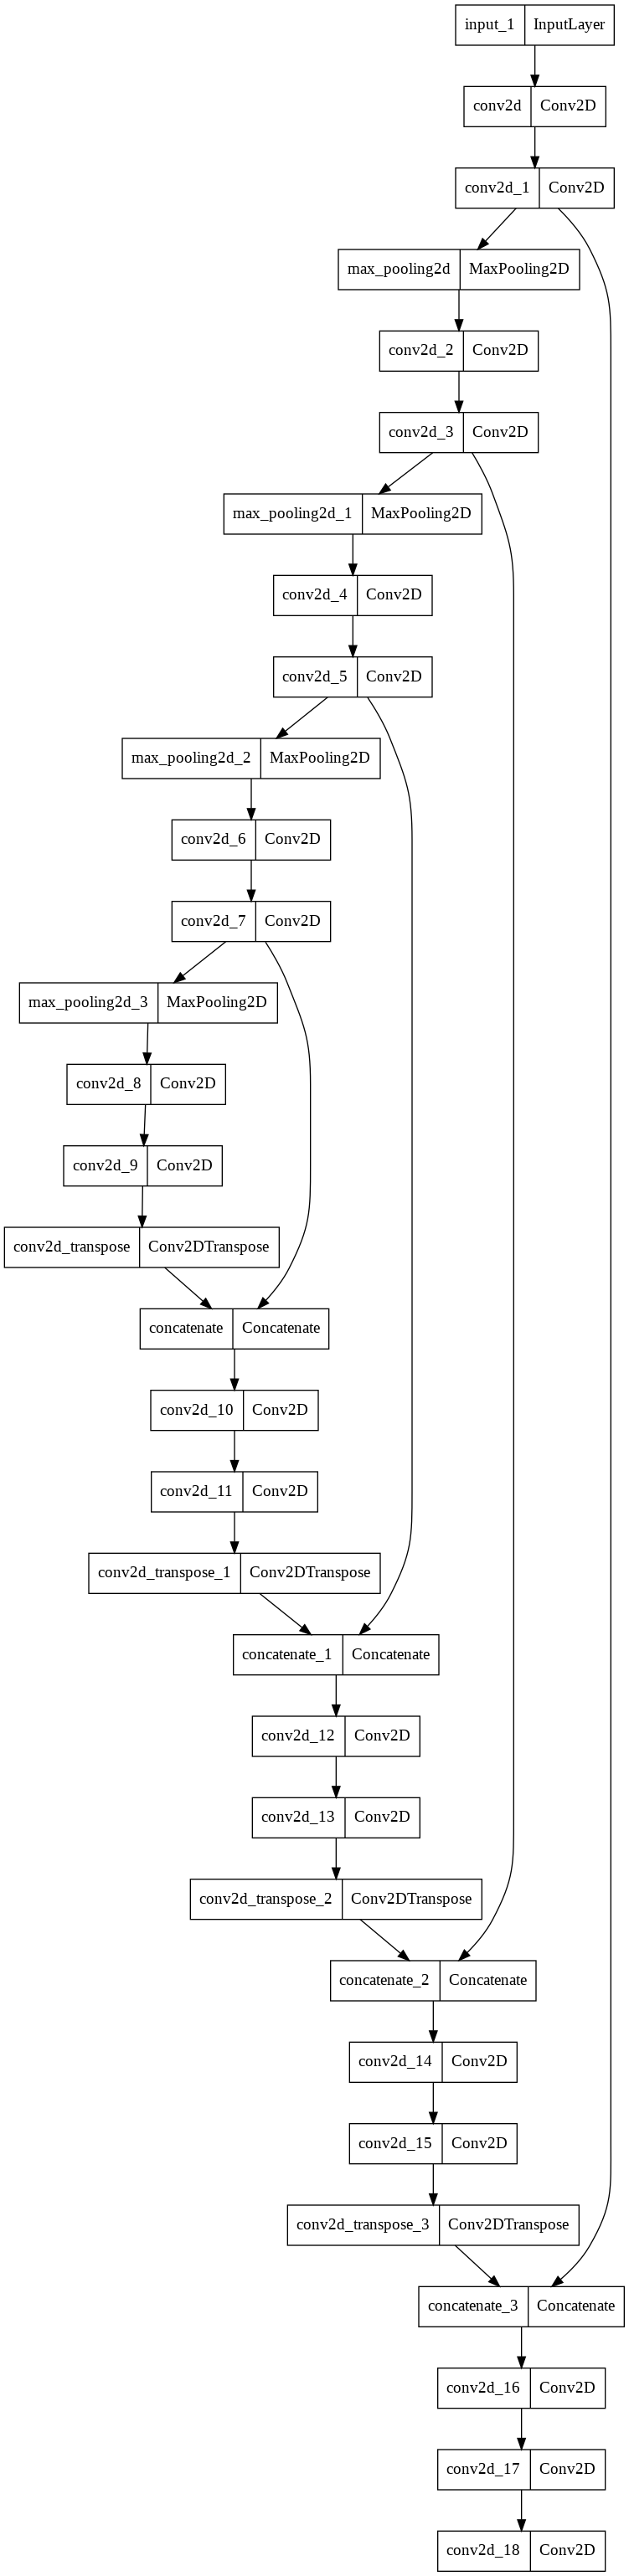

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='simple_model.png')